In [ ]:
from datetime import datetime
from datetime import timezone

import pytz
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import *
from pyspark.sql.types import *

from helpers import read_parquet_as_pd_df, preprocess_spain_fuel_price_df

SEABORN_PALETTE = "colorblind"
SEABORN_FIGURE_FIGSIZE = (12, 10)

sns.set_palette(SEABORN_PALETTE)
sns.set(rc={'figure.figsize': SEABORN_FIGURE_FIGSIZE})

In [2]:
BUCKET = "spain-fuel-prices"

label_list = ["repsol", "cepsa", "bp", "shell", "galp", "disa", "ballenoil", "carrefour", "plenoil", "petroprix", "costco"]
columns = [
    "timestamp",
    "zip_code",
    "eess_id",
    "ccaa_id",
    "municipality_id",
    "province_id",
    "sale_type",
    "label",
    "address",
    "municipality",
    "province",
    "locality",
    "latitude",
    "longitude",
    "biodiesel_price",
    "bioethanol_price",
    "compressed_natural_gas_price",
    "liquefied_natural_gas_price",
    "liquefied_petroleum_gases_price",
    "diesel_a_price",
    "diesel_b_price",
    "diesel_premium_price",
    "gasoline_95_e10_price",
    "gasoline_95_e5_price",
    "gasoline_95_e5_premium_price",
    "gasoline_98_e10_price",
    "gasoline_98_e5_price",
    "hydrogen_price",
]

In [ ]:
pd_fuel_df = read_parquet_as_pd_df(BUCKET)
pd_fuel_df = preprocess_spain_fuel_price_df(pd_fuel_df, label_list)

In [4]:
pd_fuel_df.tail()

,timestamp,zip_code,eess_id,ccaa_id,municipality_id,province_id,sale_type,label,address,municipality,...,diesel_a_price,diesel_b_price,diesel_premium_price,gasoline_95_e10_price,gasoline_95_e5_price,gasoline_95_e5_premium_price,gasoline_98_e10_price,gasoline_98_e5_price,hydrogen_price,date
477265,2024-11-19 11:02:22+00:00,50197,12472,2,8108,50,p,ids,"ronda feria de muestras, de la, 20",zaragoza,...,1.479,1.222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-11-19
477266,2024-11-19 11:02:22+00:00,50197,13917,2,8108,50,p,noil,"poligono calle turiaso, 31",zaragoza,...,1.409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-11-19
477267,2024-11-19 11:02:22+00:00,50800,9085,2,8109,50,p,an energeticos - zuera,"calle austria, 11,17",zuera,...,1.371,0.901,1.411,NaN,1.475,NaN,NaN,NaN,NaN,2024-11-19
477268,2024-11-19 11:02:22+00:00,50800,1452,2,8109,50,p,repsol,"carretera n-330a km. 24,000",zuera,...,1.449,1.128,NaN,NaN,1.539,NaN,NaN,1.689,NaN,2024-11-19
477269,2024-11-19 11:02:22+00:00,50810,9068,2,8109,50,p,cooperativa san isidro,"calle cooperativa, 2",zuera,...,1.361,0.901,1.401,NaN,1.475,NaN,NaN,NaN,NaN,2024-11-19


In [5]:
price_columns = [column for column in pd_fuel_df.columns if column.endswith("price")]

## Provinces, Municipalities, and Localities

In [6]:
pd_fuel_df["province"].unique().__len__(), pd_fuel_df["province"].unique()

(52,
 array(['albacete', 'alicante', 'almería', 'araba/álava', 'asturias',
        'ávila', 'badajoz', 'balears (illes)', 'barcelona', 'bizkaia',
        'burgos', 'cáceres', 'cádiz', 'cantabria', 'castellón / castelló',
        'ceuta', 'ciudad real', 'córdoba', 'coruña (a)', 'cuenca',
        'gipuzkoa', 'girona', 'granada', 'guadalajara', 'huelva', 'huesca',
        'jaén', 'león', 'lleida', 'lugo', 'madrid', 'málaga', 'melilla',
        'murcia', 'navarra', 'ourense', 'palencia', 'palmas (las)',
        'pontevedra', 'rioja (la)', 'salamanca', 'santa cruz de tenerife',
        'segovia', 'sevilla', 'soria', 'tarragona', 'teruel', 'toledo',
        'valencia / valència', 'valladolid', 'zamora', 'zaragoza'],
       dtype=object))

In [7]:
pd_fuel_df["municipality"].unique().__len__(), pd_fuel_df["locality"].unique().__len__(),

(3473, 4317)

In [8]:
pd_fuel_df.loc[pd_fuel_df["province"] == "madrid", "municipality"].unique().__len__()

109

In [9]:
pd_fuel_df.loc[pd_fuel_df["municipality"] == "madrid", "locality"].unique().__len__()

1

## Zip Codes per Province, Municipality and Locality

In [10]:
pd_fuel_df.groupby('province')['zip_code'].nunique()

province
albacete                   69
alicante                  129
almería                    76
araba/álava                33
asturias                  124
badajoz                   129
balears (illes)            86
barcelona                 253
bizkaia                    64
burgos                     68
cantabria                  86
castellón / castelló       64
ceuta                       2
ciudad real                82
coruña (a)                142
cuenca                     94
cáceres                    89
cádiz                      72
córdoba                    87
gipuzkoa                   52
girona                    103
granada                   114
guadalajara                44
huelva                     65
huesca                     78
jaén                       96
león                       89
lleida                    109
lugo                       78
madrid                    196
melilla                     4
murcia                    124
málaga                     94
n

In [11]:
distinct_counts = pd_fuel_df.groupby('municipality')['zip_code'].nunique().reset_index()
distinct_counts[distinct_counts['zip_code'] > 2]

,municipality,zip_code
16,adeje,4
33,agüimes,4
58,albacete,10
87,albuñol,3
94,alcalá de henares,5
...,...,...
3400,viveiro,3
3406,vélez-málaga,5
3438,zamora,8
3440,zaragoza,24


In [12]:
distinct_counts = pd_fuel_df.groupby('locality')['zip_code'].nunique().reset_index()
distinct_counts[distinct_counts['zip_code'] > 2]

,locality,zip_code
48,aguimes,4
80,albacete,8
120,alcala de henares,5
146,alcobendas,3
156,alcorcon,6
...,...,...
3924,valladolid,11
4015,vigo,13
4245,vitoria-gasteiz,8
4287,zamora,8


### Madrid

In [13]:
pd_fuel_df.loc[pd_fuel_df["province"] == "madrid", "zip_code"].unique().__len__()

196

In [14]:
pd_fuel_df.loc[pd_fuel_df["municipality"] == "madrid", "zip_code"].unique().__len__()

51

In [15]:
pd_fuel_df.loc[pd_fuel_df["locality"] == "madrid", "zip_code"].unique().__len__()

51

## Spain Average Fuel Price per Province

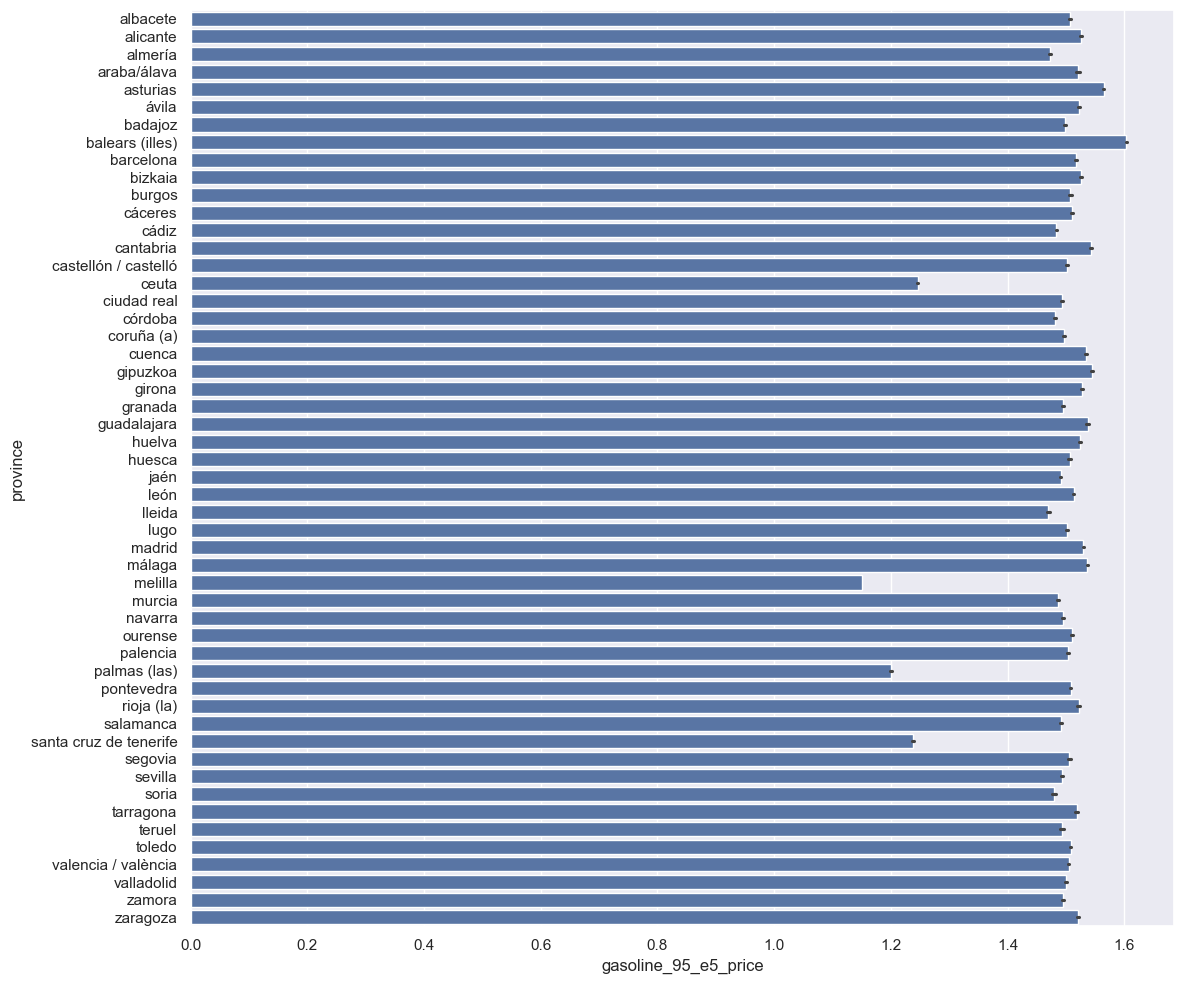

In [16]:
sns.barplot(data=pd_fuel_df, x="gasoline_95_e5_price", y="province", orient="h")
plt.tight_layout()

## Madrid gasoline_95_e5_price per Municipality

In [17]:
top_10_cheapest_mean_gas_price = (
    pd_fuel_df.loc[
        (pd_fuel_df["province"] == "madrid"), 
        ["municipality", "gasoline_95_e5_price"]
    ]
    .groupby(["municipality"]).describe()
    .reset_index()
    ["gasoline_95_e5_price"]["mean"]
    .sort_values()
    [:10]
)

In [18]:
(
    pd_fuel_df.loc[
        (pd_fuel_df["province"] == "madrid"), 
        ["municipality", "gasoline_95_e5_price"]
    ]
    .groupby(["municipality"]).describe()
    .reset_index()
    .iloc[top_10_cheapest_mean_gas_price.index, :]
)

municipality gasoline_95_e5_price                             \
                                             count      mean       std    min   
87          torrejón de ardoz               1059.0  1.392296  0.105148  1.249   
61              navas del rey                 80.0  1.413562  0.046109  1.339   
10      becerril de la sierra                 40.0  1.430225  0.013014  1.412   
65                      parla                560.0  1.430736  0.104337  1.275   
92       torres de la alameda                120.0  1.434417  0.088442  1.325   
55        moraleja de enmedio                120.0  1.438383  0.080916  1.339   
95                  valdemoro                598.0  1.447950  0.080758  1.299   
33                fuenlabrada               1000.0  1.457584  0.096427  1.339   
81  santa maría de la alameda                 40.0  1.469650  0.015749  1.435   
22               ciempozuelos                240.0  1.472467  0.091658  1.359   

                                    
        25%    50%      75%    max  
87  1.31400  1.349  1.45900  1.649  
61  1.37275  1.389  1.45900  1.479  
10  1.42050  1.427  1.43825  1.467  
65  1.35900  1.389  1.56900  1.609  
92  1.36500  1.385  1.55025  1.569  
55  1.37900  1.399  1.54900  1.559  
95  1.36900  1.449  1.52900  1.559  
33  1.37900  1.399  1.57900  1.619  
81  1.46500  1.475  1.47900  1.495  
22  1.39900  1.434  1.58900  1.629

In [19]:
top_10_most_expensive_mean_gas_price = (
    pd_fuel_df.loc[
        (pd_fuel_df["province"] == "madrid"), 
        ["municipality", "gasoline_95_e5_price"]
    ]
    .groupby(["municipality"]).describe()
    .reset_index()
    ["gasoline_95_e5_price"]["mean"]
    .sort_values(ascending=False)
    [:10]
)

In [20]:
(
    pd_fuel_df.loc[
        (pd_fuel_df["province"] == "madrid"), 
        ["municipality", "gasoline_95_e5_price"]
    ]
    .groupby(["municipality"]).describe()
    .reset_index()
    .iloc[top_10_most_expensive_mean_gas_price.index, :]
)

municipality gasoline_95_e5_price                          \
                                            count      mean           std   
62              nuevo baztán                 40.0  1.643000  1.721657e-02   
84                somosierra                 40.0  1.642150  1.520214e-02   
98                 venturada                 40.0  1.639500  1.880398e-02   
67         perales de tajuña                200.0  1.636910  1.854566e-02   
57          morata de tajuña                 40.0  1.632000  2.248733e-16   
59               navacerrada                 80.0  1.620650  2.094786e-02   
75  san agustín del guadalix                 40.0  1.618000  1.007663e-02   
88    torrejón de la calzada                 80.0  1.617025  7.704963e-03   
39     guadalix de la sierra                 40.0  1.616500  2.227451e-02   
54                molar (el)                 80.0  1.615750  2.029997e-02   

                                          
      min      25%    50%     75%    max  
62  1.602  1.64200  1.652  1.6520  1.652  
84  1.597  1.63400  1.641  1.6540  1.664  
98  1.599  1.62900  1.649  1.6490  1.659  
67  1.584  1.62900  1.639  1.6520  1.674  
57  1.632  1.63200  1.632  1.6320  1.632  
59  1.574  1.60475  1.629  1.6355  1.652  
75  1.609  1.60900  1.609  1.6290  1.629  
88  1.604  1.61275  1.618  1.6240  1.629  
39  1.569  1.59900  1.619  1.6390  1.649  
54  1.599  1.59900  1.599  1.6390  1.649

## Madrid gasoline_95_e5_price per Locality

In [21]:
top_10_cheapest_mean_gas_price = (
    pd_fuel_df.loc[
        (pd_fuel_df["province"] == "madrid"), 
        ["locality", "gasoline_95_e5_price"]
    ]
    .groupby(["locality"]).describe()
    .reset_index()
    ["gasoline_95_e5_price"]["mean"]
    .sort_values()
    [:10]
)

In [22]:
(
    pd_fuel_df.loc[
        (pd_fuel_df["province"] == "madrid"), 
        ["locality", "gasoline_95_e5_price"]
    ]
    .groupby(["locality"]).describe()
    .reset_index()
    .iloc[top_10_cheapest_mean_gas_price.index, :]
)

locality gasoline_95_e5_price                      \
                                                count      mean       std   
13                    base aerea                 40.0  1.323500  0.012800   
19                  caballo (el)                 40.0  1.376375  0.009999   
108            valmor-rompecubas                 40.0  1.386000  0.011117   
71                  nieves (las)                 40.0  1.392000  0.010178   
98             torrejon de ardoz               1019.0  1.394996  0.106259   
90   san martin de valdeiglesias                 40.0  1.413000  0.010328   
70                 navas del rey                 80.0  1.413562  0.046109   
14         becerril de la sierra                 40.0  1.430225  0.013014   
76                         parla                560.0  1.430736  0.104337   
41                 frailes (los)                 40.0  1.431500  0.010801   

                                             
       min      25%     50%      75%    max  
13   1.299  1.31900  1.3290  1.32900  1.339  
19   1.364  1.36900  1.3715  1.38900  1.404  
108  1.359  1.37900  1.3880  1.39800  1.399  
71   1.379  1.38900  1.3890  1.38900  1.429  
98   1.249  1.31400  1.3490  1.49800  1.649  
90   1.399  1.40650  1.4140  1.41900  1.429  
70   1.339  1.37275  1.3890  1.45900  1.479  
14   1.412  1.42050  1.4270  1.43825  1.467  
76   1.275  1.35900  1.3890  1.56900  1.609  
41   1.409  1.41900  1.4290  1.43900  1.449

In [23]:
top_10_most_expensive_mean_gas_price = (
    pd_fuel_df.loc[
        (pd_fuel_df["province"] == "madrid"), 
        ["locality", "gasoline_95_e5_price"]
    ]
    .groupby(["locality"]).describe()
    .reset_index()
    ["gasoline_95_e5_price"]["mean"]
    .sort_values(ascending=False)
    [:10]
)

In [24]:
(
    pd_fuel_df.loc[
        (pd_fuel_df["province"] == "madrid"), 
        ["locality", "gasoline_95_e5_price"]
    ]
    .groupby(["locality"]).describe()
    .reset_index()
    .iloc[top_10_most_expensive_mean_gas_price.index, :]
)

locality gasoline_95_e5_price                          \
                                             count      mean           std   
72               nuevo baztan                 40.0  1.643000  1.721657e-02   
95                 somosierra                 40.0  1.642150  1.520214e-02   
110                 venturada                 40.0  1.639500  1.880398e-02   
78          perales de tajuña                200.0  1.636910  1.854566e-02   
66           morata de tajuña                 40.0  1.632000  2.248733e-16   
68                navacerrada                 80.0  1.620650  2.094786e-02   
54                    loeches                120.0  1.620083  3.832185e-02   
86   san agustin del guadalix                 40.0  1.618000  1.007663e-02   
99     torrejon de la calzada                 80.0  1.617025  7.704963e-03   
48      guadalix de la sierra                 40.0  1.616500  2.227451e-02   

                                           
       min      25%    50%     75%    max  
72   1.602  1.64200  1.652  1.6520  1.652  
95   1.597  1.63400  1.641  1.6540  1.664  
110  1.599  1.62900  1.649  1.6490  1.659  
78   1.584  1.62900  1.639  1.6520  1.674  
66   1.632  1.63200  1.632  1.6320  1.632  
68   1.574  1.60475  1.629  1.6355  1.652  
54   1.549  1.57900  1.639  1.6490  1.659  
86   1.609  1.60900  1.609  1.6290  1.629  
99   1.604  1.61275  1.618  1.6240  1.629  
48   1.569  1.59900  1.619  1.6390  1.649

## Madrid gasoline_95_e5_price per Label

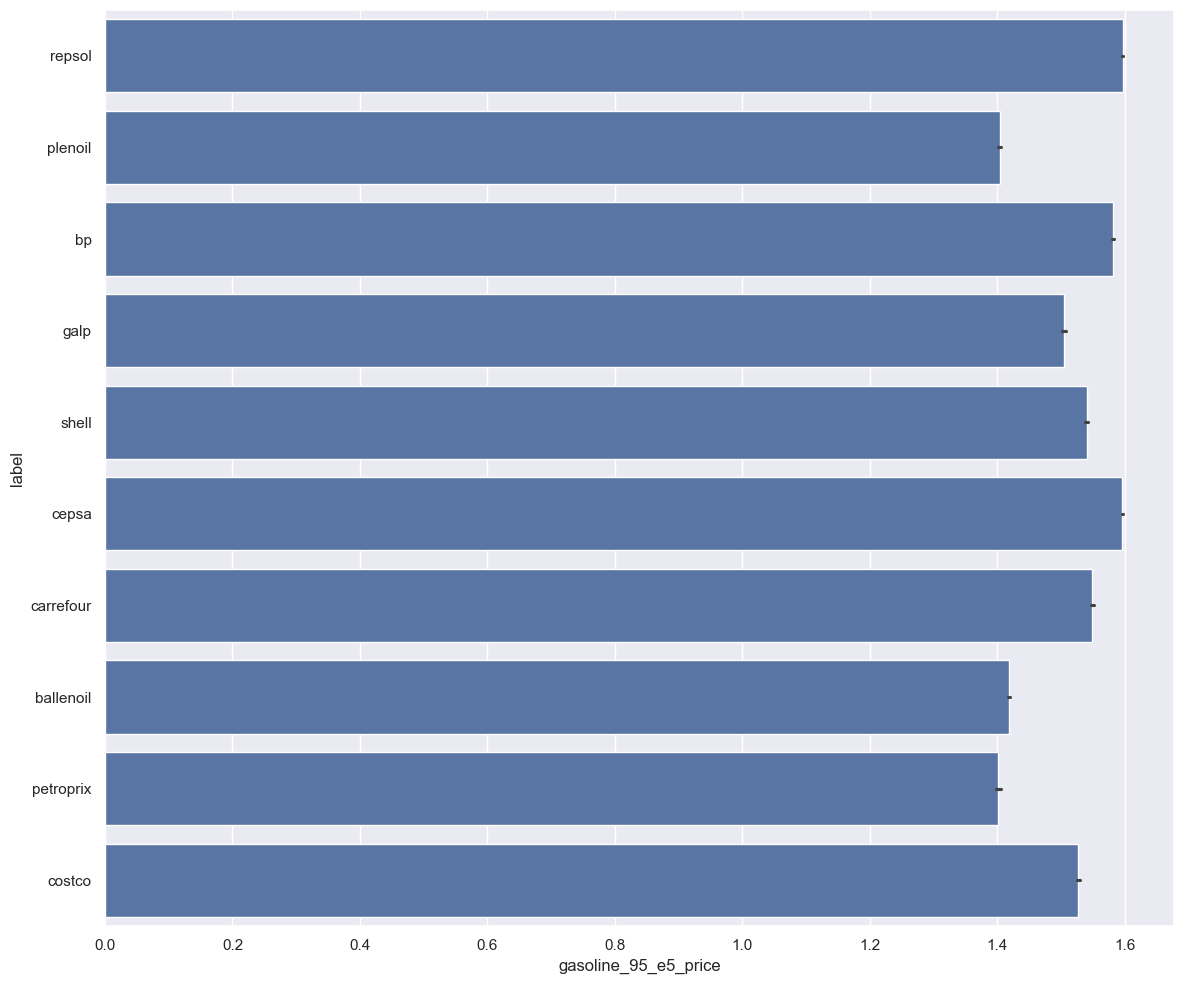

In [25]:
sns.barplot(
    data=pd_fuel_df.loc[(pd_fuel_df["province"] == "madrid")  & pd_fuel_df["label"].isin(label_list), ["label", "gasoline_95_e5_price"]],
    x="gasoline_95_e5_price",
    y="label",
    orient="h",
)
plt.tight_layout()

## Madrid gasoline_95_e5_price per ZipCode

In [26]:
(
    pd_fuel_df.loc[(pd_fuel_df["municipality"] == "madrid"), ["zip_code", "gasoline_95_e5_price"]]
    .groupby("zip_code").mean()
    .sort_values("gasoline_95_e5_price")
    .reset_index()
)

,zip_code,gasoline_95_e5_price
0,28000,1.447997
1,28021,1.459865
2,28038,1.467000
3,28044,1.477366
4,28054,1.490442
5,28041,1.494050
6,28031,1.497961
7,28052,1.500010
8,28032,1.502421
9,28022,1.516412


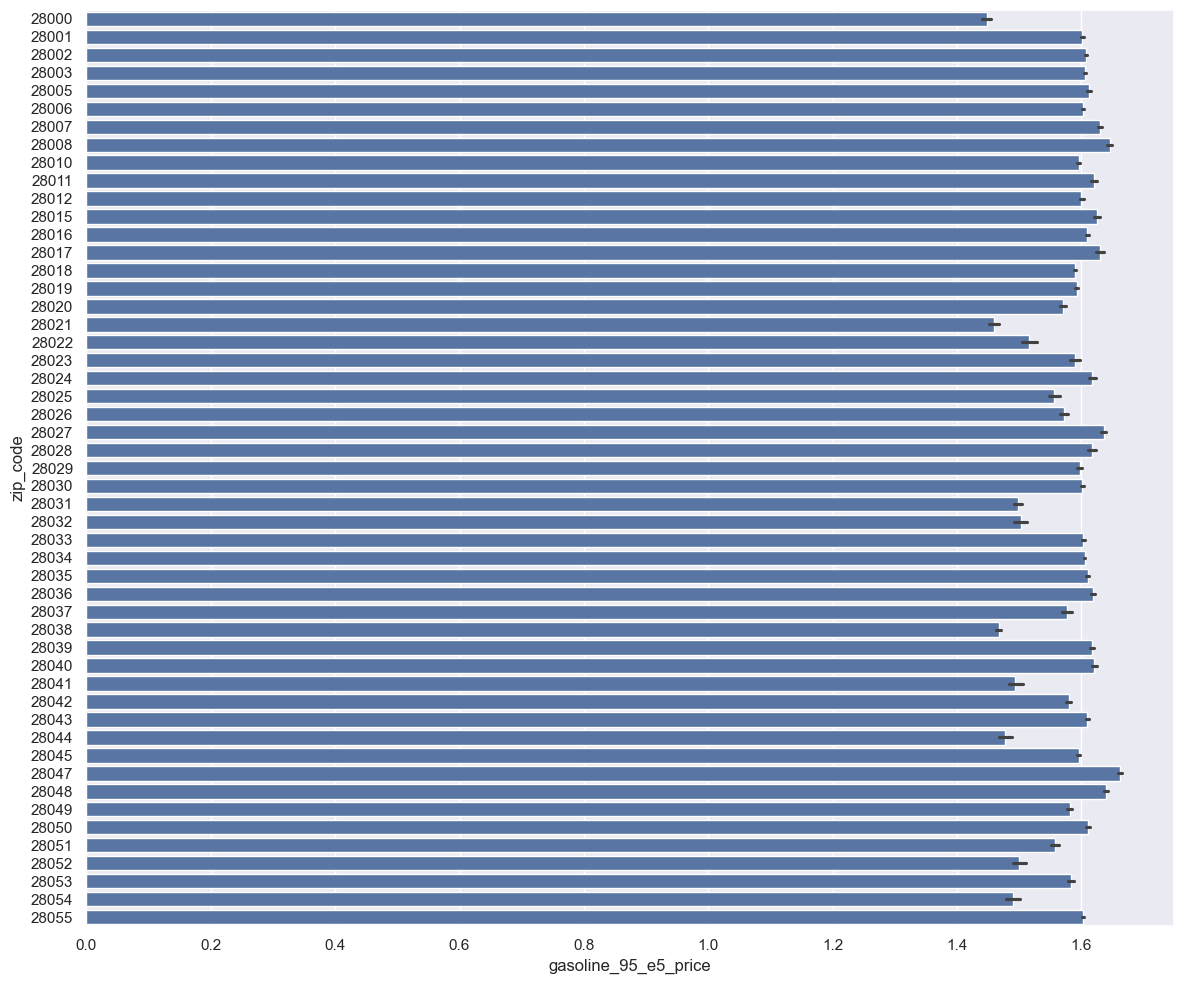

In [27]:
sns.barplot(
    data=pd_fuel_df.loc[(pd_fuel_df["municipality"] == "madrid"), ["zip_code", "gasoline_95_e5_price"]],
    x="gasoline_95_e5_price",
    y="zip_code",
    orient="h",
)
plt.tight_layout()

## Favorite EESS (Zip Code = 28050)

In [28]:
pd_fuel_df.loc[pd_fuel_df["zip_code"] == 28050, ["gasoline_95_e5_price", "gasoline_95_e5_premium_price", "gasoline_98_e5_price"]].describe()

,gasoline_95_e5_price,gasoline_95_e5_premium_price,gasoline_98_e5_price
count,120.000000,40.000000,120.000000
mean,1.610500,1.653650,1.760725
std,0.019668,0.007597,0.019669
min,1.589000,1.639000,1.729000
25%,1.599000,1.649000,1.749000
50%,1.605000,1.659000,1.757000
75%,1.609250,1.659000,1.769000
max,1.669000,1.659000,1.809000


In [29]:
unique_addresses = pd_fuel_df[(pd_fuel_df["zip_code"] == 28050) & pd_fuel_df["gasoline_95_e5_price"].notna()]["address"].unique()

mask = (
        (pd_fuel_df["zip_code"] == 28050) 
        & pd_fuel_df["timestamp"].notna() 
        & pd_fuel_df["gasoline_95_e5_price"].notna()
)

In [30]:
pd_fuel_df.loc[(pd_fuel_df["zip_code"] == 28050) & pd_fuel_df["gasoline_95_e5_price"].notna(), ["timestamp", "address", "gasoline_95_e5_price"]].groupby("address").describe()

gasoline_95_e5_price                             \
                                           count      mean       std    min   
address                                                                       
avenida manoteras, 34                       40.0  1.627075  0.025284  1.589   
calle abetal, 8                             40.0  1.603650  0.007597  1.589   
calle maria de portugal, 15                 40.0  1.600775  0.007512  1.589   

                                                         
                               25%    50%    75%    max  
address                                                  
avenida manoteras, 34        1.604  1.629  1.649  1.669  
calle abetal, 8              1.599  1.609  1.609  1.609  
calle maria de portugal, 15  1.595  1.603  1.605  1.622

In [31]:
pd_fuel_df[pd_fuel_df["province"] == "madrid"]["locality"].unique()

array(['ajalvir', 'alamo (el)', 'alcala de henares', 'alcobendas',
       'alcorcon', 'aldea del fresno', 'algete', 'alpedrete', 'aranjuez',
       'arganda', 'arroyomolinos', 'becerril de la sierra',
       'boadilla del monte', 'cerceda', 'brunete', 'buitrago del lozoya',
       'cabrera (la)', 'cadalso de los vidrios', 'campo real',
       'casarrubuelos', 'cenicientos', 'cercedilla', 'chinchon',
       'ciempozuelos', 'cobeña', 'collado mediano', 'collado villalba',
       'villalba de guadarrama', 'colmenar de oreja',
       'colmenar del arroyo', 'colmenar viejo', 'coslada',
       'daganzo de arriba', 'frailes (los)', 'escorial (el)', 'estremera',
       'fuenlabrada', 'fuente el saz de jarama', 'fuentidueña de tajo',
       'galapagar', 'getafe', 'aldehuela y la torrecilla (la)', 'griñon',
       'guadalix de la sierra', 'guadarrama', 'horcajo de la sierra',
       'hoyo de manzanares', 'humanes de madrid', 'leganes', 'butarque',
       'fortuna', 'loeches', 'caballo (el)', 'lo

In [32]:
sorted(pd_fuel_df[pd_fuel_df["zip_code"] == 28031]["locality"].unique())

['madrid']

In [33]:
pd_fuel_df.loc[pd_fuel_df["province"] == "madrid", ["timestamp", "zip_code", "sale_type", "label", "province", "municipality", "locality", "gasoline_95_e5_price"]
].groupby(["municipality", "label"])["gasoline_95_e5_price"].describe().head(50)

count      mean       std    min      25%  \
municipality      label                                                       
ajalvir           plenoil          40.0  1.429000  0.011094  1.419  1.41900   
                  repsol           80.0  1.576875  0.008958  1.549  1.56900   
alcalá de henares alcampo          40.0  1.402000  0.004641  1.399  1.39900   
                  avia             40.0  1.431500  0.010801  1.409  1.41900   
                  ballenoil        80.0  1.384625  0.009119  1.369  1.37900   
                  bp              120.0  1.544667  0.063494  1.429  1.47900   
                  carrefour        40.0  1.539750  0.021290  1.499  1.53900   
                  cepsa           120.0  1.596067  0.020435  1.554  1.58275   
                  energy           40.0  1.469000  0.000000  1.469  1.46900   
                  galp            200.0  1.424475  0.054329  1.339  1.38900   
                  gasexpress       40.0  1.376750  0.004797  1.369  1.37650   
                  lavaplus         40.0  1.375000  0.007442  1.339  1.36900   
                  petroprix        40.0  1.320000  0.032801  1.259  1.28900   
                  plenoil          40.0  1.300000  0.023621  1.249  1.28900   
                  repsol          200.0  1.578870  0.009232  1.549  1.57350   
                  shell           120.0  1.482667  0.045926  1.418  1.42900   
                  supeco           40.0  1.374750  0.011297  1.339  1.37650   
alcobendas        alcampo          40.0  1.456000  0.009661  1.449  1.44900   
                  ballenoil        80.0  1.452625  0.004838  1.449  1.44900   
                  bp              120.0  1.595750  0.013167  1.569  1.58900   
                  carrefour        40.0  1.572000  0.012026  1.549  1.56900   
                  cepsa            80.0  1.612963  0.020799  1.569  1.59575   
                  combus           40.0  1.458000  0.010077  1.449  1.44900   
                  galp            120.0  1.535625  0.046891  1.469  1.49900   
                  petroprix        80.0  1.452250  0.004713  1.449  1.44900   
                  repsol          240.0  1.600125  0.014880  1.569  1.59900   
                  scat             40.0  1.454850  0.014549  1.438  1.44400   
                  shell            40.0  1.578700  0.012678  1.564  1.56800   
alcorcón          alcampo          40.0  1.392500  0.013311  1.369  1.37900   
                  aliara energía    0.0       NaN       NaN    NaN      NaN   
                  avia             80.0  1.479000  0.008859  1.459  1.46900   
                  ballenoil        80.0  1.430375  0.020730  1.379  1.41900   
                  bp              280.0  1.600536  0.007951  1.589  1.59900   
                  cepsa           120.0  1.571100  0.038388  1.519  1.53900   
                  lavaplus         40.0  1.366500  0.012352  1.339  1.36900   
                  naturgy           0.0       NaN       NaN    NaN      NaN   
                  petroprix        40.0  1.423250  0.015340  1.379  1.41900   
                  plenoil         120.0  1.429500  0.018050  1.379  1.41900   
                  redexis           0.0       NaN       NaN    NaN      NaN   
                  repsol          200.0  1.601200  0.012161  1.569  1.59900   
                  shell           120.0  1.483250  0.015646  1.459  1.46900   
                  solner           40.0  1.472250  0.015752  1.439  1.46900   
aldea del fresno  cepsa            40.0  1.579675  0.028094  1.544  1.55400   
algete            ballenoil        40.0  1.469425  0.002241  1.468  1.46900   
                  bp               40.0  1.542500  0.015115  1.509  1.53900   
                  repsol           80.0  1.539538  0.010006  1.519  1.53900   
                  shell            40.0  1.498900  0.000304  1.498  1.49900   
alpedrete         cepsa            40.0  1.579200  0.024855  1.534  1.56400   
                  petroprix        40.0  1.441325  0.009900  1.429  1.43700   
     

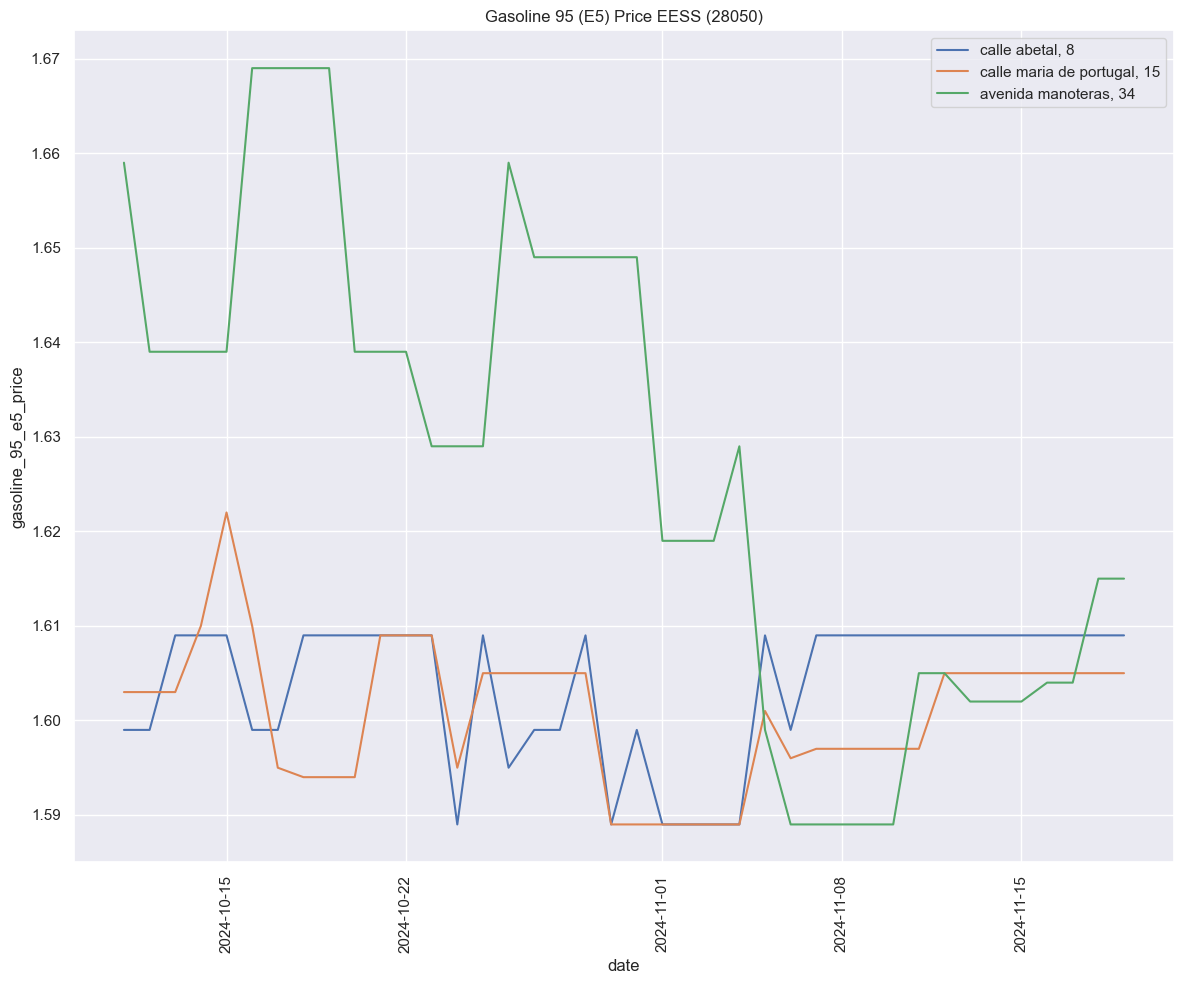

In [34]:
for address in unique_addresses:
    data_to_plot = pd_fuel_df.loc[mask & (pd_fuel_df["address"] == address), ["date", "address", "gasoline_95_e5_price"]]
    sns.lineplot(
        data=data_to_plot,
        x="date",
        y="gasoline_95_e5_price",
        label=address,
    )

plt.title("Gasoline 95 (E5) Price EESS (28050)")
plt.xticks(rotation=90)
plt.tight_layout()